# Neural network classification

Neural network classification uses a neural network to categorize data into different classes



In [1]:
# classification data set
from sklearn.datasets import make_circles

# 1000 samples
n_samples =1000

x,y = make_circles(n_samples,noise=0.03,random_state=42)

In [2]:
len(x), len(y)

(1000, 1000)

In [3]:
print(x[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [4]:
# make a data frame
import pandas as pd
df = pd.DataFrame({"x1":x[:,0],"x2":x[:,1],"label":y})
df.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


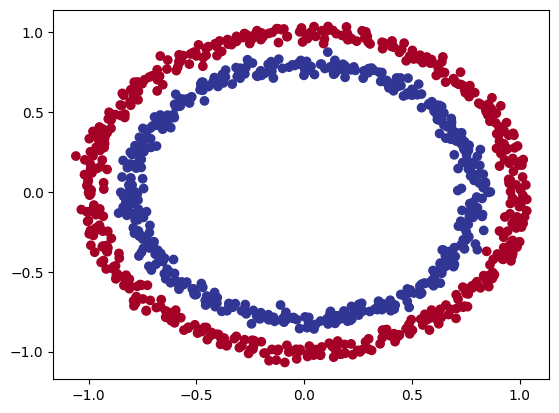

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.RdYlBu)
plt.show()

# check input and output shape

In [6]:
x.shape , y.shape

((1000, 2), (1000,))

In [7]:
x

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [8]:
x_sample=x[0]
y_sample=y[0]

x_sample


array([0.75424625, 0.23148074])

In [9]:
y_sample

np.int64(1)

## Turn data into tensors create train and split

In [10]:
import torch
torch.__version__

'2.6.0+cu124'

In [11]:
type(x), x.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# changing to tensor make it to convert ndarrays from float 64 to float 32 which is
# default size of pytorch

x=torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.float)



In [13]:
x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
x.dtype,y.dtype

(torch.float32, torch.float32)

In [15]:
# split training data and testing data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)



In [16]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# pytorch work flow

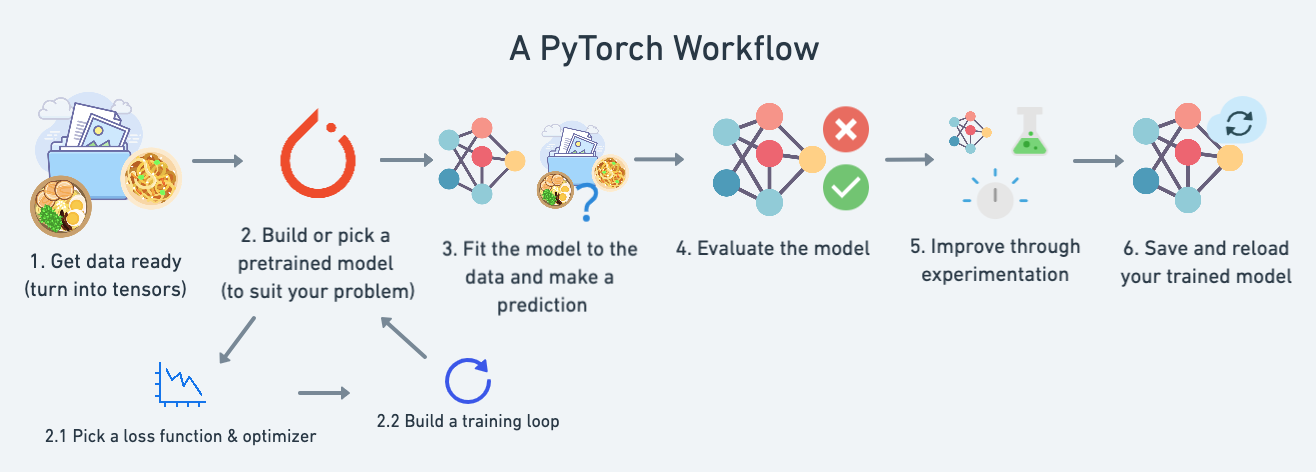


# building a model

bulding a model to classify the Tensor
1. setup device agonistic code so our code will run on an torch.accelerator
2. construct a model
3. define loss function
4. create taining loop

In [17]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
device="cuda"
torch.device("cuda")
torch.cuda.is_available()

False

setup a device agnostic code create a model that:

1.subclass `nn.module`

2.create 2 `nn.linear()` layers that are capable of handling the shapes of our data

3.defines a `forward()` method that outlines the forward pass


In [19]:
# construct a model that subclass nn.module

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    # creating linear layers capable of handling the shapes of our data

    self.layer_1=nn.Linear(in_features=2,out_features=5)  # takes in 2 features and upscales to 5 features (it is like a hidden layer for getting more values of an feature to train the model)
    self.layer_2=nn.Linear(in_features=5,out_features=1)  # output layer

    # Note : the in features of the second layer should always matches the out_features of the first layer

  def forward(self,x):
   return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

model_0 = CircleModel()
model_0


CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
device

'cuda'

In [21]:
model_0.parameters()

<generator object Module.parameters at 0x7dfadf3bf3e0>

In [22]:
# replicate above model using nn.sequential

model_0 =nn.Sequential(
    nn.Linear(in_features=2,out_features=5), # input layer : 2 parameters gives out 5 feature parameters
    nn.Linear(in_features=5,out_features=1)  # hiddenlayer : the out put features should match the input features of 2nd layer
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3566,  0.2485],
                      [-0.2285,  0.4867],
                      [ 0.5372, -0.3402],
                      [-0.5337,  0.6095],
                      [-0.5393, -0.2864]])),
             ('0.bias', tensor([ 0.1524,  0.3378,  0.3704, -0.6850, -0.4736])),
             ('1.weight',
              tensor([[-0.3397, -0.2545, -0.1340, -0.3408, -0.2013]])),
             ('1.bias', tensor([-0.1496]))])

In [24]:
# making predictions
untrained_pred = model_0(x_test)

with torch.inference_mode():
  untrained_pred = model_0(x_test)

untrained_pred[:5]

tensor([[-0.3709],
        [-0.3024],
        [-0.1893],
        [-0.4239],
        [ 0.3845]])

In [25]:
# visualizing the predictions of the untrained data

def plot_prediction(x_train=x_train,
                     y_train=y_train,
                     x_test=x_test,
                     y_test=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=40, label="training data")
  # plot test data in green
  plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=40, label="test data")
  if predictions is not None:
    # plot the predictions in red (predictions were made on the test data)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=predictions, s=40, label="predictions")



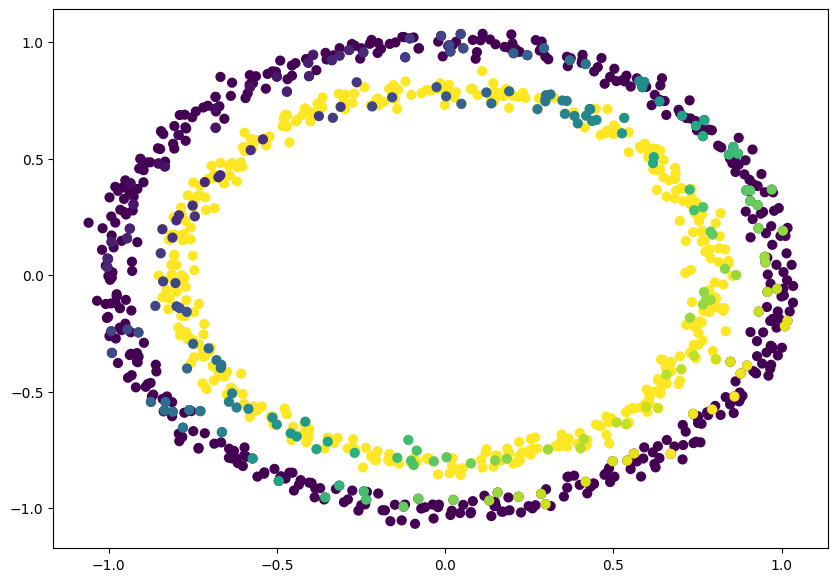

In [26]:
plot_prediction(predictions=untrained_pred.squeeze(dim=1))

# creating a loss function and optimizer
which loss function and optimizer should use


for regression you might want MAE or MSE

for classification you might want binary cross entropy or categorical cross entropy

loss function measures how wrong model predictions are

`Activation function` : in neural networks a mathematical equations that determine the output of a neuron given its input.

* they introduce non linearity into the network allowing it to learn complex patterns in data.

* Essentially they decide whether a neurons signal should be passed on to next layer

Types :    
   * `Sigmoid`: Outputs a value between 0 and 1, often used in output layers for binary classification.

* `Tanh`: Outputs a value between -1 and 1.

* `ReLU` (Rectified Linear Unit): Outputs the input if it's positive, and 0 otherwise. A very popular choice due to its simplicity and effectiveness.

* `Softmax`: Converts a vector of numbers into a probability distribution, often used in the output layer for multi-class classification.

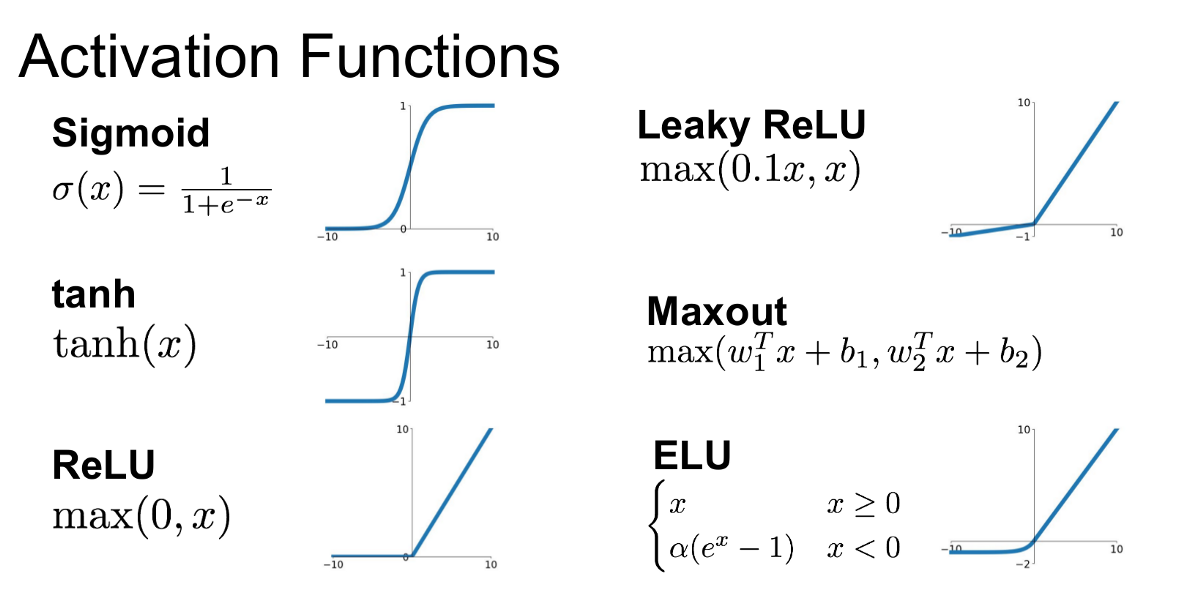

In [27]:
# creating an loss function and optimizer

# loss_fn=nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built in

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [28]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3566,  0.2485],
                      [-0.2285,  0.4867],
                      [ 0.5372, -0.3402],
                      [-0.5337,  0.6095],
                      [-0.5393, -0.2864]])),
             ('0.bias', tensor([ 0.1524,  0.3378,  0.3704, -0.6850, -0.4736])),
             ('1.weight',
              tensor([[-0.3397, -0.2545, -0.1340, -0.3408, -0.2013]])),
             ('1.bias', tensor([-0.1496]))])

In [29]:
# calculate the accuracy : percentage does our model get right

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# train model

forward pass

calculate the loss

optimizer zero grad

loss backward (backpropagation)

optimizer (gradient descent)

# going from raw logits -> prediction probabilities -> prediction labels

`logits` : they represent the raw unnormalized scores produced by the last layer of a neural network before these scores are transformed into probabilities

sigmoid for binary classification

softmax for multi class classification

In [30]:
# view first 5 outputs for forward pass
model_0.eval()

with torch.inference_mode():

 y_logits = model_0(x_test[:5])
 y_logits

In [31]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [32]:
# use sigmoid activation function on model logits into predictions probabilities

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4083],
        [0.4250],
        [0.4528],
        [0.3956],
        [0.5950]])

for our prediction probability we need to perform a range syle rounding on them:

* y_pred_probs >= 0.5, y=1 class 1
* y_pred_probs < 0.5, y=0 class 0

In [33]:
y_preds=torch.round(y_pred_probs)

# logits to pred probs to pred labels
y_pred_labels =torch.round(torch.sigmoid(model_0(x_test[:5])))

# check for quality
print(torch.eq(y_preds, y_pred_labels))

y_preds.squeeze( )

tensor([[True],
        [True],
        [True],
        [True],
        [True]])


tensor([0., 0., 0., 0., 1.])

In [34]:
# building a training and testing model

torch.manual_seed(42)

epochs = 1000


# x_train, y_train = x_train.to(device), y_train.to(device)
# x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # model training
    model_0.train()

    # forward pass
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss calculation

    loss =loss_fn(torch.sigmoid(y_logits), y_train) # nn.bcewithlogits expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)


# optimizer zero grad
    optimizer.zero_grad()

# loss backward (backpropagation)
    loss.backward()

# optimizer (gradient descent)
    optimizer.step()


    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate test loss
        test_loss = loss_fn(torch.sigmoid(test_logits), y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 100 ==0 :
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.72492 | Acc: 50.38% | Test Loss: 0.72339 | Test Acc: 47.50%
Epoch: 100 | Loss: 0.72288 | Acc: 49.62% | Test Loss: 0.72139 | Test Acc: 47.00%
Epoch: 200 | Loss: 0.72095 | Acc: 49.00% | Test Loss: 0.71951 | Test Acc: 47.00%
Epoch: 300 | Loss: 0.71914 | Acc: 47.75% | Test Loss: 0.71775 | Test Acc: 46.50%
Epoch: 400 | Loss: 0.71745 | Acc: 46.25% | Test Loss: 0.71611 | Test Acc: 45.00%
Epoch: 500 | Loss: 0.71588 | Acc: 40.62% | Test Loss: 0.71458 | Test Acc: 43.00%
Epoch: 600 | Loss: 0.71441 | Acc: 50.00% | Test Loss: 0.71317 | Test Acc: 50.00%
Epoch: 700 | Loss: 0.71305 | Acc: 50.00% | Test Loss: 0.71185 | Test Acc: 50.00%
Epoch: 800 | Loss: 0.71180 | Acc: 50.00% | Test Loss: 0.71064 | Test Acc: 50.00%
Epoch: 900 | Loss: 0.71064 | Acc: 50.00% | Test Loss: 0.70952 | Test Acc: 50.00%


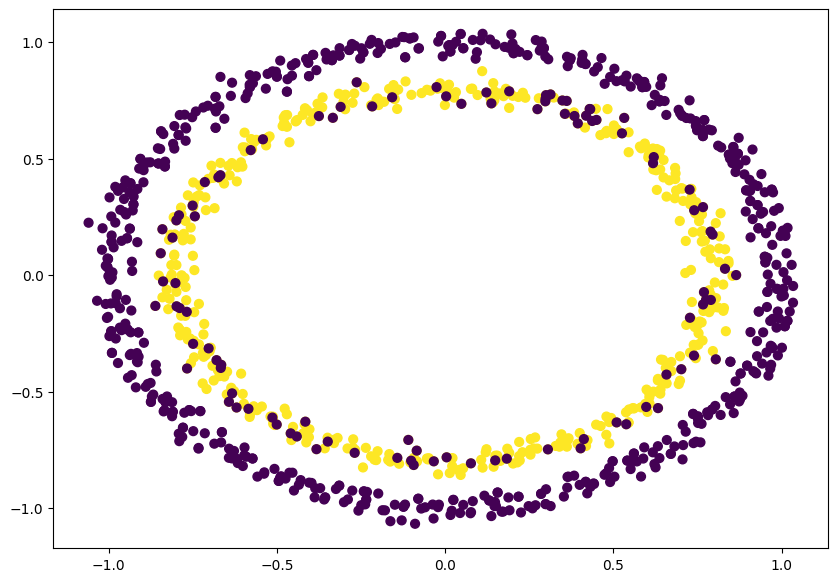

In [35]:
# make predictions and evaluate model

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(x_test)
    y_pred = torch.round(torch.sigmoid(y_logits))



plot_prediction(predictions=y_pred)

In [36]:
import requests
from pathlib import Path
# helps to download files from pytorch repo
# download helper functions from pytorch repo

if Path("helper_functions.py").is_file():
    print("helper functions already downloaded")
else:
    print("downloading helper functions")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


from helper_functions import  plot_predictions, plot_decision_boundary

downloading helper functions


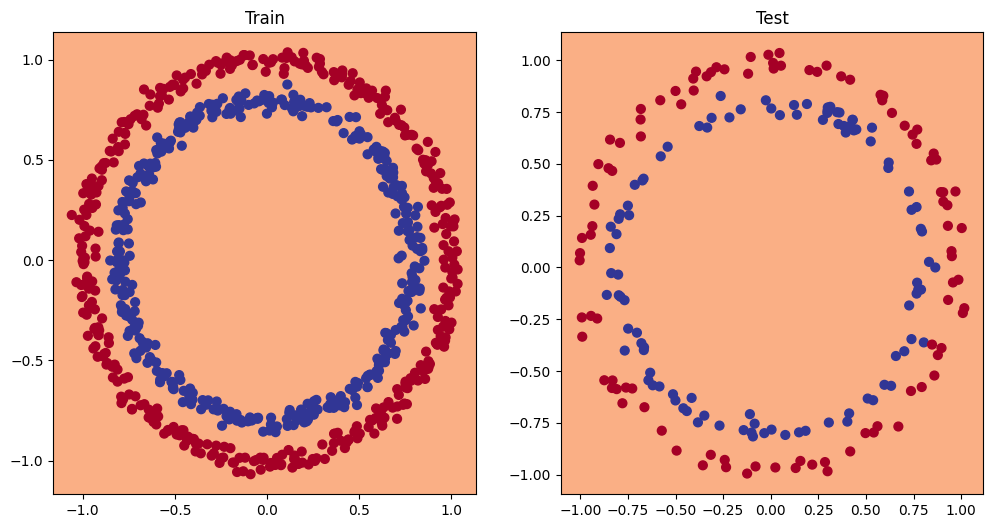

In [37]:
# plot decision boundary o fmodel
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

# improving a model

* add more layers - give model more chances to learn about in data
* add more hidden units - from 5 to 10 hidden
* fit for longer
* changing the activation functions
* change the learning rate
* high learning rate can cause exploding gradient descent
* change the loss function

`Exploding gradient descent `: occurs when gradients, used to update network weights during training, become excessively large, causing unstable learning and potentially preventing the network from converging to a good solution

In [38]:
class Circles(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1= nn.Linear(in_features=2, out_features=10)
    self.layer2= nn.Linear(in_features=10, out_features=10)
    self.layer3= nn.Linear(in_features=10, out_features=1)

  def forward(self,X):
    return self.layer3(self.layer2(self.layer1(X)))

model_1=Circles()
model_1


# in built function to make layers

model_3 = nn.Sequential(
    nn.Linear(in_features=2, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=1)
)

model_3

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)

In [39]:
model_3.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579],
                      [-0.0338,  0.3948],
                      [-0.1807, -0.4035],
                      [-0.2421, -0.5283],
                      [ 0.2522,  0.5473],
                      [-0.6657,  0.1642],
                      [ 0.3653,  0.1282],
                      [-0.2518,  0.3691],
                      [ 0.3716,  0.2644],
                      [-0.1243, -0.1872],
                      [ 0.0756, -0.1249],
                      [-0.2107,  0.4520],
                      [ 0.6077, -0.0700],
                      [-0.1583,  0.0103],
        

In [40]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3501,  0.2345],
                      [-0.2232,  0.4753],
                      [ 0.5407, -0.3479],
                      [-0.5294,  0.6001],
                      [-0.5367, -0.2920]])),
             ('0.bias', tensor([ 0.2399,  0.4089,  0.4179, -0.6249, -0.4377])),
             ('1.weight',
              tensor([[-0.3721, -0.3233, -0.2540, -0.1467, -0.0910]])),
             ('1.bias', tensor([-0.3965]))])

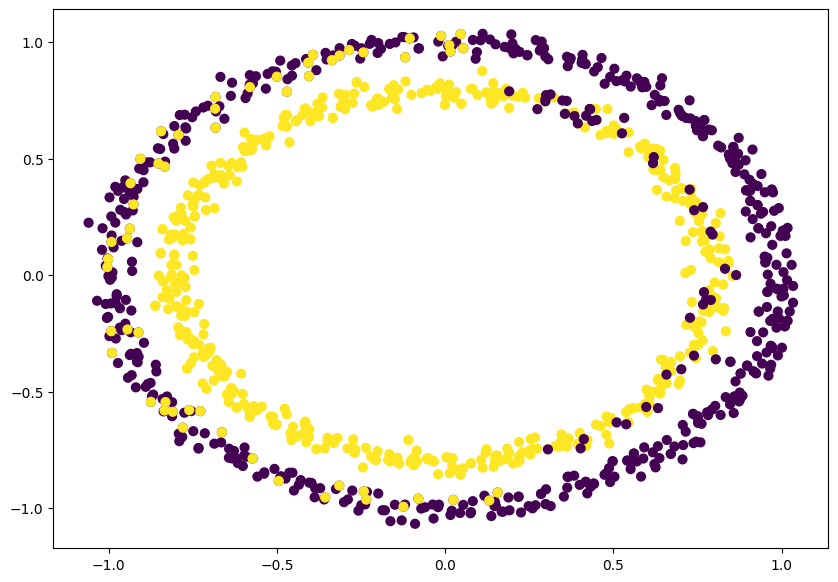

In [41]:
model_1.eval()

with torch.inference_mode():
  y_logits = model_1(x_test)
  y_pred = torch.round(torch.sigmoid(y_logits))

plot_prediction(predictions=y_pred)


In [42]:
# create a loss function

loss_fn = nn.BCEWithLogitsLoss();

# create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

In [43]:
# creating a an training loop
torch.manual_seed(42)

epochs = 3500

for epoch in range(epochs):
  # training model
  model_3.train()

  # forward pass
  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss back ward
  loss.backward()

  # optimizer step
  optimizer.step()

  ## testing
  model_3.eval()

  with torch.inference_mode():

    # forward pass
    test_logits=model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69700 | Acc: 49.00% | Test Loss: 0.69578 | Test Acc: 48.50%
Epoch: 100 | Loss: 0.69255 | Acc: 51.00% | Test Loss: 0.69253 | Test Acc: 48.50%
Epoch: 200 | Loss: 0.68973 | Acc: 52.25% | Test Loss: 0.69063 | Test Acc: 47.50%
Epoch: 300 | Loss: 0.68719 | Acc: 55.62% | Test Loss: 0.68885 | Test Acc: 51.50%
Epoch: 400 | Loss: 0.68499 | Acc: 60.50% | Test Loss: 0.68736 | Test Acc: 56.50%
Epoch: 500 | Loss: 0.68280 | Acc: 61.12% | Test Loss: 0.68578 | Test Acc: 57.00%
Epoch: 600 | Loss: 0.68063 | Acc: 67.62% | Test Loss: 0.68417 | Test Acc: 61.00%
Epoch: 700 | Loss: 0.67841 | Acc: 71.75% | Test Loss: 0.68247 | Test Acc: 63.50%
Epoch: 800 | Loss: 0.67608 | Acc: 75.12% | Test Loss: 0.68068 | Test Acc: 67.50%
Epoch: 900 | Loss: 0.67359 | Acc: 76.25% | Test Loss: 0.67876 | Test Acc: 67.00%
Epoch: 1000 | Loss: 0.67095 | Acc: 76.25% | Test Loss: 0.67666 | Test Acc: 69.50%
Epoch: 1100 | Loss: 0.66809 | Acc: 77.62% | Test Loss: 0.67431 | Test Acc: 70.50%
Epoch: 1200 | Loss: 0.66486 

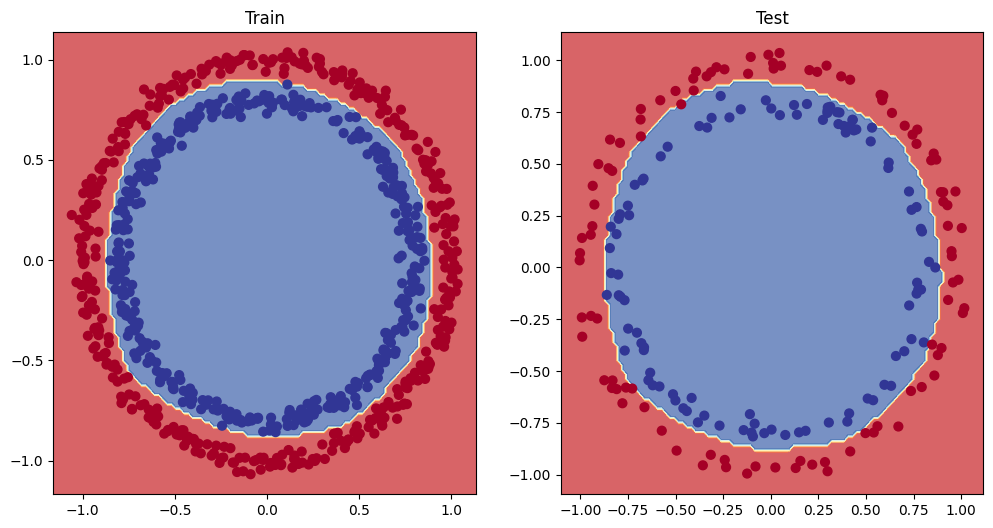

In [44]:
# plot decision boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, x_test, y_test)

In [45]:
## preparing data to see if model can fit a straight line

# create data
weight =0.7
bias =0.3

x_regression=torch.arange(0,1,0.01).unsqueeze(dim=1)
y_regression=weight * x_regression + bias


# check data
print(x_regression[:10], y_regression[:10])

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]]) tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280],
        [0.3350],
        [0.3420],
        [0.3490],
        [0.3560],
        [0.3630]])


In [46]:
# create train and test splits

train_split = int(0.8 * len(x_regression))
x_train_regression, y_train_regression = x_regression[:train_split], y_regression[:train_split]
x_test_regression, y_test_regression = x_regression[train_split:], y_regression[train_split:]

len(x_train_regression), len(y_train_regression), len(x_test_regression), len(y_test_regression)

(80, 80, 20, 20)

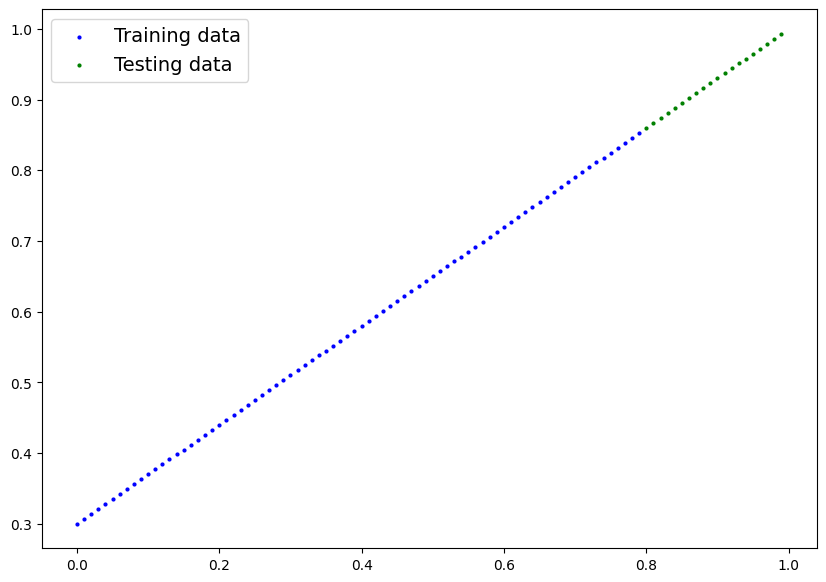

In [47]:
plot_predictions(train_data=x_train_regression,
                 train_labels =y_train_regression,
                 test_data =x_test_regression,
                 test_labels =y_test_regression)


# adjusting model 1 to fit a straight line

In [48]:
# same architecture as model_1

model_2=nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
# loss and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [50]:
# building a training and testing loop
torch.manual_seed(42)


epochs = 1000

for epoch in range(epochs):
  model_2.train()

  # forward pass
  y_pred = model_2(x_train_regression)
  loss = loss_fn(y_pred, y_train_regression)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # optimizer step
  optimizer.step()


  # testing the model
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(x_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

    if epoch %10==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")



Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 10 | Loss: 0.40240 | Test Loss: 0.50474
Epoch: 20 | Loss: 0.06007 | Test Loss: 0.10151
Epoch: 30 | Loss: 0.01559 | Test Loss: 0.03231
Epoch: 40 | Loss: 0.03092 | Test Loss: 0.00111
Epoch: 50 | Loss: 0.03196 | Test Loss: 0.00108
Epoch: 60 | Loss: 0.03192 | Test Loss: 0.00170
Epoch: 70 | Loss: 0.03081 | Test Loss: 0.00097
Epoch: 80 | Loss: 0.03077 | Test Loss: 0.00150
Epoch: 90 | Loss: 0.02967 | Test Loss: 0.00092
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 110 | Loss: 0.02962 | Test Loss: 0.00197
Epoch: 120 | Loss: 0.02748 | Test Loss: 0.00091
Epoch: 130 | Loss: 0.02852 | Test Loss: 0.00181
Epoch: 140 | Loss: 0.02850 | Test Loss: 0.00246
Epoch: 150 | Loss: 0.02744 | Test Loss: 0.00169
Epoch: 160 | Loss: 0.02638 | Test Loss: 0.00123
Epoch: 170 | Loss: 0.02637 | Test Loss: 0.00162
Epoch: 180 | Loss: 0.02532 | Test Loss: 0.00125
Epoch: 190 | Loss: 0.02636 | Test Loss: 0.00284
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epo

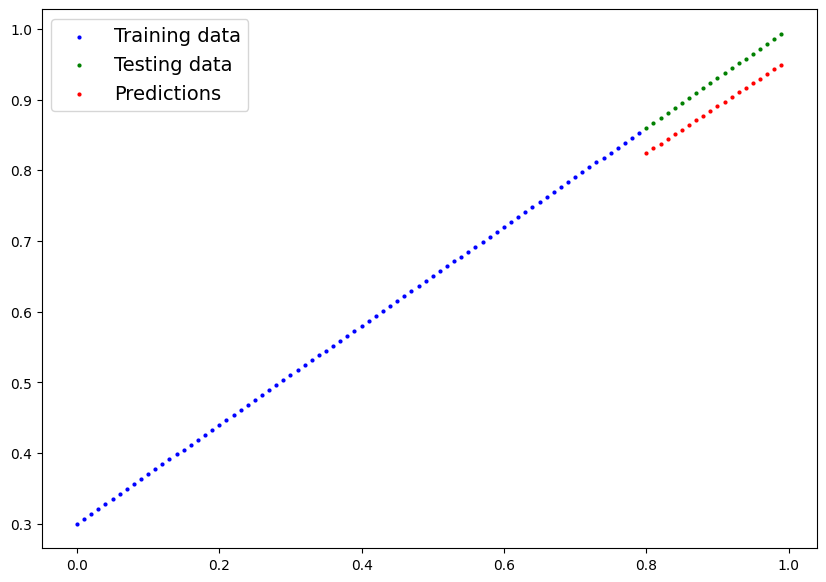

In [51]:
# turn on evaluation mode

model_2.eval()

with torch.inference_mode():
  y_preds = model_2(x_test_regression)

# plot data
plot_predictions(train_data=x_train_regression,
                 train_labels =y_train_regression,
                 test_data =x_test_regression,
                 test_labels =y_test_regression,
                 predictions=y_preds)

# missing piece : Non-linearity
**`Non linear function`** : A mathematical function where the output does not change at a constant rate in relation to the input.

* this mean its graph is not a straight line it can be curved .


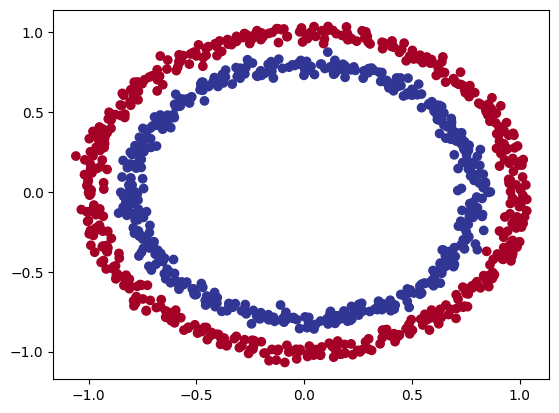

In [52]:
## Recreating non-linear data
# make a plot data

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

x, y = make_circles(n_samples,noise=0.03,random_state=42)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [53]:
# convert data to tensors for train and test

import torch
from sklearn.model_selection import train_test_split

x_tensor = torch.from_numpy(x).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

# split

x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42)

In [54]:
x_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# building a model  
linear = straight lines

Non linear = non-straight lines

In [55]:
# non linear activations model
from torch import nn

class CircleModelv3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 =nn.Linear(in_features=2, out_features=10)
    self.layer2 =nn.Linear(in_features=10, out_features=10)
    self.layer3 =nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non linear activation function
    # self.sigmoid =nn.sigmoid() we can use  sigmoid activaion

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_4 = CircleModelv3()
model_4


CircleModelv3(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [56]:
model_4.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310

In [57]:
# building loss function

loss_fn = nn.BCEWithLogitsLoss()

# building an optimizer

optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [58]:
# building a training loop with non linearity
torch.manual_seed(42)


epochs = 4000

for epoch in range(epochs):
  model_4.train()

  # forward pass
  y_logits = model_4(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # step optimizer
  optimizer.step()

  # testing the model
  model_4.eval()
  with torch.inference_mode():
    y_logits = model_4(x_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits to predictions to predictions labels

    test_loss = loss_fn(y_logits, y_test)
    acc = accuracy_fn(y_true=y_test, y_pred=y_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.3f} | Test Loss: {test_loss:.3f} | test_acc:{acc:.3f}")



Epoch: 0 | Loss: 0.693 | Test Loss: 0.693 | test_acc:50.000
Epoch: 100 | Loss: 0.691 | Test Loss: 0.691 | test_acc:52.500
Epoch: 200 | Loss: 0.690 | Test Loss: 0.689 | test_acc:55.000
Epoch: 300 | Loss: 0.688 | Test Loss: 0.687 | test_acc:56.000
Epoch: 400 | Loss: 0.685 | Test Loss: 0.684 | test_acc:56.500
Epoch: 500 | Loss: 0.681 | Test Loss: 0.679 | test_acc:56.500
Epoch: 600 | Loss: 0.675 | Test Loss: 0.673 | test_acc:56.000
Epoch: 700 | Loss: 0.667 | Test Loss: 0.663 | test_acc:59.000
Epoch: 800 | Loss: 0.652 | Test Loss: 0.648 | test_acc:67.500
Epoch: 900 | Loss: 0.624 | Test Loss: 0.621 | test_acc:79.000
Epoch: 1000 | Loss: 0.568 | Test Loss: 0.574 | test_acc:86.500
Epoch: 1100 | Loss: 0.482 | Test Loss: 0.499 | test_acc:90.500
Epoch: 1200 | Loss: 0.371 | Test Loss: 0.406 | test_acc:92.000
Epoch: 1300 | Loss: 0.255 | Test Loss: 0.303 | test_acc:96.500
Epoch: 1400 | Loss: 0.172 | Test Loss: 0.221 | test_acc:97.500
Epoch: 1500 | Loss: 0.122 | Test Loss: 0.165 | test_acc:99.000
Epoc

In [59]:
model_4.eval()
with torch.inference_mode():
  y_pred = torch.round(torch.sigmoid(model_4(x_test)).squeeze())
y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

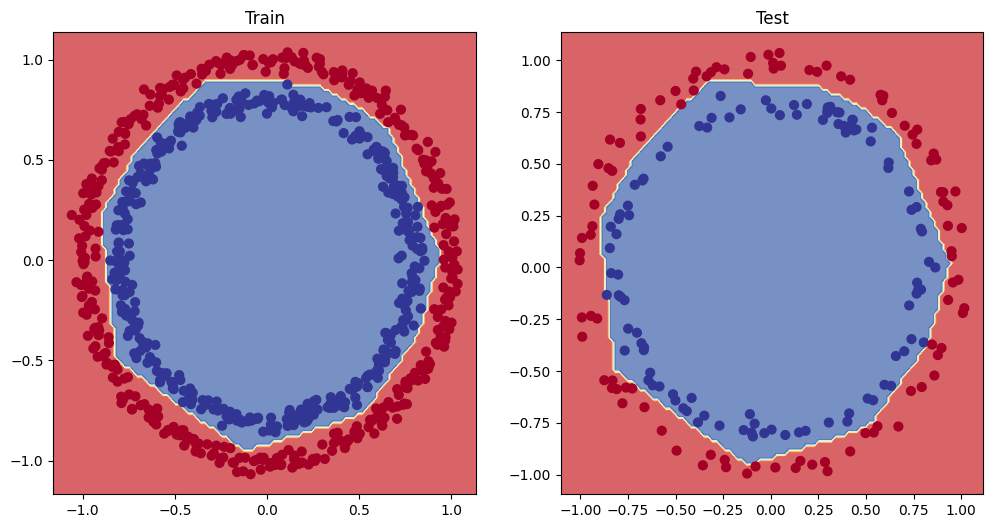

In [60]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, x_test, y_test)

In [61]:
# replicating non linear activation functions
# create a tensor

A =torch.arange(-10, 10, 0.1)
A.dtype

torch.float32

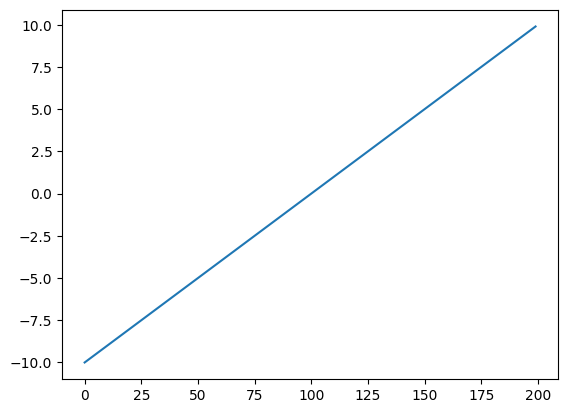

In [62]:
# visualize
plt.plot(A)

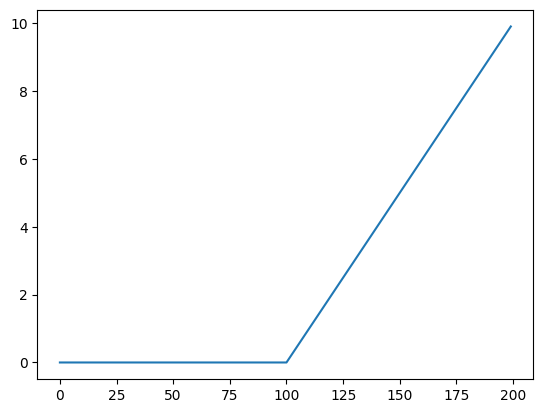

In [63]:
plt.plot(torch.relu(A))

In [64]:
def relu(x:torch.Tensor)->torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000,
        0.8000, 0.9000, 1.0000, 1.1000, 

In [65]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 5.0172e-05, 5.5449e-05, 6.1280e-05, 6.7724e-05, 7.4846e-05,
        8.2717e-05, 9.1416e-05, 1.0103e-04, 1.1165e-04, 1.2339e-04, 1.3637e-04,
        1.5071e-04, 1.6656e-04, 1.8407e-04, 2.0343e-04, 2.2482e-04, 2.4846e-04,
        2.7458e-04, 3.0345e-04, 3.3535e-04, 3.7061e-04, 4.0957e-04, 4.5262e-04,
        5.0020e-04, 5.5278e-04, 6.1088e-04, 6.7508e-04, 7.4603e-04, 8.2442e-04,
        9.1105e-04, 1.0068e-03, 1.1125e-03, 1.2294e-03, 1.3585e-03, 1.5012e-03,
        1.6588e-03, 1.8329e-03, 2.0253e-03, 2.2378e-03, 2.4726e-03, 2.7320e-03,
        3.0184e-03, 3.3348e-03, 3.6842e-03, 4.0701e-03, 4.4963e-03, 4.9668e-03,
        5.4863e-03, 6.0598e-03, 6.6929e-03, 7.3915e-03, 8.1626e-03, 9.0133e-03,
        9.9518e-03, 1.0987e-02, 1.2128e-02, 1.3387e-02, 1.4774e-02, 1.6302e-02,
        1.7986e-02, 1.9840e-02, 2.1881e-02, 2.4127e-02, 2.6597e-02, 2.9312e-02,
        3.2295e-02, 3.5571e-02, 3.9166e-02, 4.3107e-02, 4.7426e-02, 5.2154e-02,
        5.7324e-02, 6.2973e-02, 6.9138e-

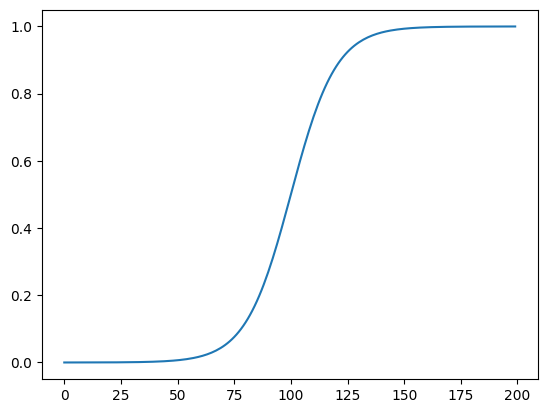

In [66]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

# Multi class classification problem

* it is the task of categorizing data instances into one of more than two predefined classes

* Binary classification = one or another thing ( eg : dog vs cat , spam Not spam)

* Multi class classification = multiple class like in food various food classes pizza, burger, chicken

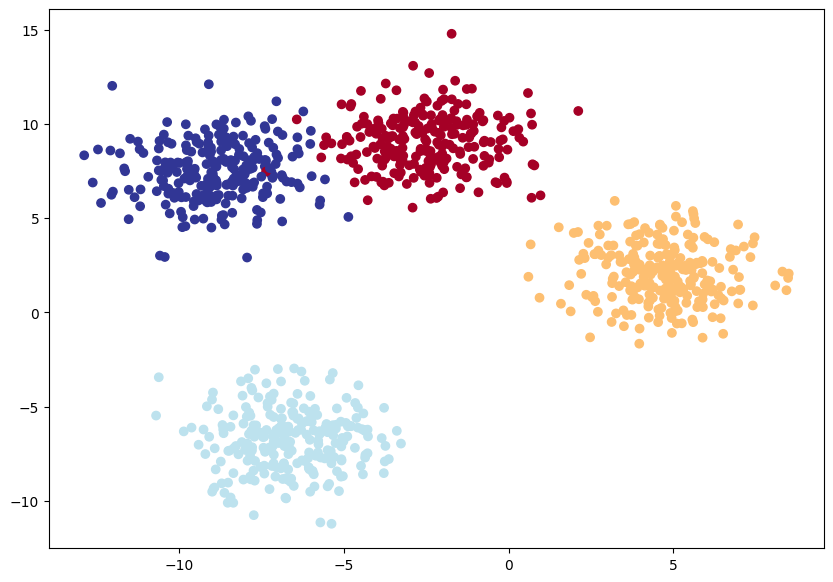

In [67]:
# creating a toy multi-class dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set parameters

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create data using make_blobs fuction
# it is used to generate syntetic datasets for machine learning tasks particularly for clustering and classification
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,  # gives the clusters a little randomness
                            random_state=RANDOM_SEED)

# turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

#split into train and test
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1],c=y_blob, cmap=plt.cm.RdYlBu)



In [117]:
# building a multiclass model

class  MulticlassModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=6):
    """
    Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.Linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Tanh(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Tanh(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.Linear_layer_stack(x)


model_5 = MulticlassModel(input_features=2, output_features=4)
model_5


MulticlassModel(
  (Linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=4, bias=True)
  )
)

In [118]:
model_5.state_dict()

OrderedDict([('Linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323]])),
             ('Linear_layer_stack.0.bias',
              tensor([ 0.5224,  0.0958,  0.3410, -0.0998,  0.5451,  0.1045])),
             ('Linear_layer_stack.2.weight',
              tensor([[-0.1906,  0.1041, -0.1881, -0.0479, -0.1658,  0.2708],
                      [-0.3223, -0.1882, -0.1153, -0.2455,  0.0385, -0.4032],
                      [ 0.3687, -0.3468,  0.3152,  0.0679, -0.1326,  0.2523],
                      [ 0.0636,  0.3298,  0.0446, -0.1288,  0.1097, -0.1107],
                      [ 0.1718,  0.3645,  0.2360, -0.1785,  0.2357,  0.0730],
                      [ 0.2073, -0.2488, -0.4041, -0.1577, -0.3131,  0.3350]])),
             ('Linear_layer_stack.2.bias',
              tenso

**CrossEntropyLoss** : also known as log loss is commonly used loss function in machine learning particularly for classification problems

* it measures the difference between two probability distributions the predicted and the true probability distribution of the data.

`Getting predictions probabilities for a multi class pytorch model`

* in order evaluate and train and test our model we need to convert our models output to prediction probabilities and then to prediction labels.

**steps**
 * logits (raw outputs of the model)
 * Pred probs (use torch.softmax)
 * preb labels take the argmax of the prediction probabilities


In [135]:
# create a loss function
loss_fn=nn.CrossEntropyLoss() # loss function measuers how wrong our models predictions are


# optimizer updates the models parameters to try and reduce the loss
# create a optimizer
optimizer = torch.optim.SGD(params=model_5.parameters(), lr=0.1) # learning rate is an hyper parameter we can change

In [136]:
# getting predictions
# convert our models logits into prediction probability
model_5.eval()
with torch.inference_mode():
  y_logits =model_5(x_blob_test)

y_logits[:5]


tensor([[   0.4893,   41.3316,  -38.0004,   -4.5978],
        [  35.5527, -113.2270,    8.9381,   65.1811],
        [ -28.7152, -124.1255,   91.3598,   61.3518],
        [ -43.0166,   31.6708,   -0.2386,   12.2739],
        [  27.6260,    1.3663,  -51.5248,   19.9485]])

In [137]:
# convert out logits into prediction probabilities to predictions labels

y_preds=torch.softmax(y_logits, dim=1).argmax(dim=1)

y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 0, 1, 0,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 0, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [138]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

In [139]:
# create a training and testing loop for multi class model

torch.manual_seed(42)

epochs =50

for epoch in range(epochs):
  model_5.train()

  # forward pass
  y_logits = model_5(x_blob_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

 # calculate the loss
  loss =loss_fn(y_logits, y_blob_train.type(torch.long)) # if the data type is in float it rises a run time error
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_preds)

  optimizer.zero_grad

  loss.backward()

  optimizer.step()

# testing
  model_5.eval()

  with torch.inference_mode():
      y_logits= model_5(x_blob_test)
      y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

      test_loss = loss_fn(y_logits, y_blob_test.type(torch.long))
      test_acc = accuracy_fn(y_true=y_blob_test, y_pred=y_preds)

      if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.3f} | Test Loss: {test_loss:.3f} |acc:{acc:3f} | test_acc:{acc:.3f}")



Epoch: 0 | Loss: 0.341 | Test Loss: 0.259 |acc:97.625000 | test_acc:97.625
Epoch: 10 | Loss: 0.721 | Test Loss: 0.615 |acc:74.250000 | test_acc:74.250
Epoch: 20 | Loss: 0.228 | Test Loss: 0.532 |acc:98.000000 | test_acc:98.000
Epoch: 30 | Loss: 0.323 | Test Loss: 0.184 |acc:98.250000 | test_acc:98.250
Epoch: 40 | Loss: 0.362 | Test Loss: 0.235 |acc:98.375000 | test_acc:98.375


In [133]:
# making predictions and evaluations

model_5.eval()
with torch.inference_mode():
  y_logits = model_5(x_blob_test)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

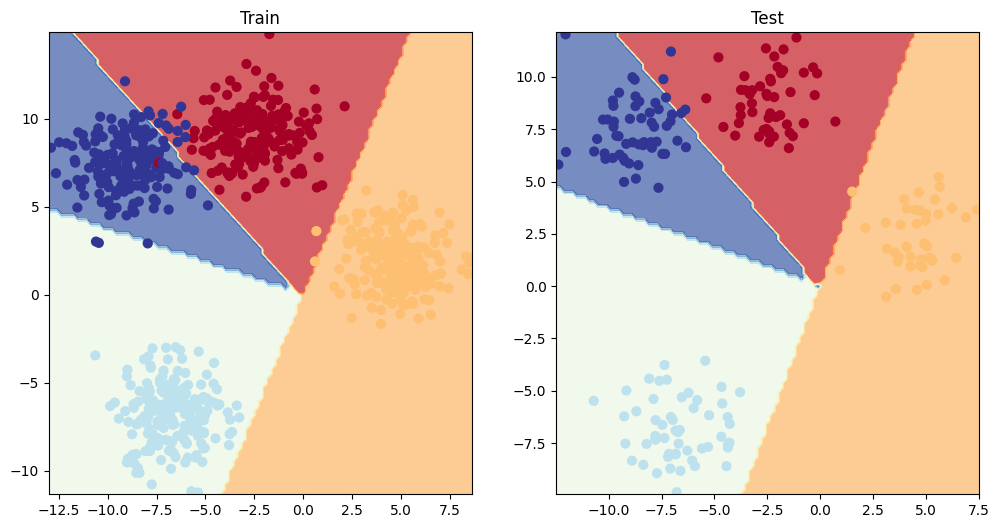

In [134]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, x_blob_test, y_blob_test)

# few more classification metrices

* Accuracy - out of 100 samples how many does our model get right_shift
* precision -
* Recall  
* f1Score
* confusion matrix
* classification report  

In [140]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [149]:
from torchmetrics import Accuracy

# setup metrics
torchmetrics_acc = Accuracy(task="multiclass", num_classes=4)

torchmetrics_acc(y_preds, y_blob_test)


tensor(0.9900)

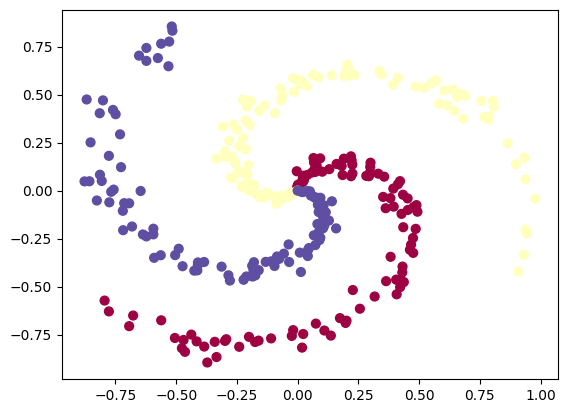

In [150]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()